In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import os

# Introduction

The following data was aggregated from raw dump files, with the following Python lines:

```python
from aggregate_dumps import *
ls = ['Cat', 'Dog', 'Selfie', 'Computer']
df = extract_keywords(ls)
df.to_csv('dummy_articles.csv')
```

Note that you should setup the `path_aggreg` in the `aggregate_dumpy.py` file.

In [2]:
!cat data/dummy_articles_README.txt


Contains articles 'Cat', 'Dog', 'Selfie', 'Computer' for all days between 2015-04-01 and 2015-02-07,
for the domains 'en', 'fr', 'es', 'ge'.

In [3]:
!head data/dummy_articles.csv

,domain,article,views,date
470589,de,Cat,11,20150401
527218,de,Computer,666,20150401
1059824,de,Dog,8,20150401
2483484,de,Selfie,232,20150401
5860547,en,Cat,5941,20150401
7976343,en,Computer,6313,20150401
8482868,en,Dog,6130,20150401
16154617,en,Selfie,1822,20150401
25983477,es,Cat,4,20150401


In [4]:
df = pd.read_csv('data/dummy_articles.csv', index_col=0)
df.date = pd.to_datetime(df.date, format='%Y%m%d')
df

,domain,article,views,date
470589,de,Cat,11,2015-04-01
527218,de,Computer,666,2015-04-01
1059824,de,Dog,8,2015-04-01
2483484,de,Selfie,232,2015-04-01
5860547,en,Cat,5941,2015-04-01
...,...,...,...,...
18456051,es,Dog,8,2015-06-14
19673274,es,Selfie,9,2015-06-14
20350947,fr,Cat,12,2015-06-14
21178711,fr,Dog,1,2015-06-14


In [5]:
domains = df.domain.unique()
domains

array(['de', 'en', 'es', 'fr'], dtype=object)

In [6]:
articles = df.article.unique()
articles

array(['Cat', 'Computer', 'Dog', 'Selfie'], dtype=object)

# Dump data visualization

In [7]:
df.sort_values('date', inplace=True)

In [8]:
df_plot = df.pivot(index=['date', 'domain'], columns='article', values='views')
df_plot.reset_index(level=1, inplace=True)
df_plot

article,domain,Cat,Computer,Dog,Selfie
date,,,,,
2015-04-01,de,11.0,666.0,8.0,232.0
2015-04-01,en,5941.0,6313.0,6130.0,1822.0
2015-04-01,es,4.0,1.0,8.0,6.0
2015-04-01,fr,13.0,8.0,1.0,445.0
2015-04-02,de,13.0,673.0,8.0,207.0
...,...,...,...,...,...
2015-07-01,fr,7.0,3.0,NaN,621.0
2015-07-02,de,15.0,754.0,15.0,253.0
2015-07-02,en,3837.0,5895.0,4348.0,1190.0


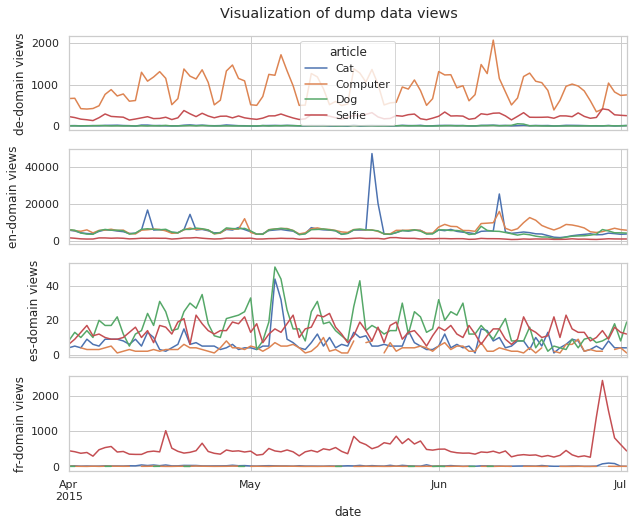

In [9]:
fig, ax = plt.subplots(len(domains), 1, figsize=(10, 8), sharex=True)
for i, (domain, a) in enumerate(zip(domains, ax)):
    df_plot[df_plot.domain == domain].plot(ax=a)
    a.set_ylabel(f'{domain}-domain views')
    if i > 0:
        a.legend().remove()
    
plt.suptitle('Visualization of dump data views', y=.93);

# Get corresponding data from API

In [10]:
from src.scrape_wiki import PageviewsClient

In [11]:
params = {
    'agent': 'user',
    'start': df.date.min().strftime('%Y%m%d'), # just to show that first 3 months are only NaNs
    'end':   '20150930'
}
params

{'agent': 'user', 'start': '20150401', 'end': '20150930'}

In [12]:
contact = 'matthias.zeller@epfl.ch'

In [13]:
# Must provide email address
p = PageviewsClient(contact)

In [14]:
def request(articles, domain='de', **kwargs):
    """Wraps the function PageviewsClient.article_views"""
    wrapped_kwargs = params.copy()
    wrapped_kwargs.update(kwargs)
    domain = domain + '.wikipedia'
    
    # Fetch
    res = p.article_views(articles=articles, project=domain, **wrapped_kwargs)
    
    # Format results in a DataFrame
    res = pd.DataFrame(res).T
    # Replace None -> np.nan
    res = res.applymap(lambda elem: np.nan if elem is None else elem)
    # Sort by dates
    res.sort_index(inplace=True)
    res.index.name = 'date'
    
    return res

In [15]:
language = 'en'

In [16]:
df_api = request(articles, domain=language)

In [17]:
df_api

,Cat,Computer,Dog,Selfie
date,,,,
2015-04-01,NaN,NaN,NaN,NaN
2015-04-02,NaN,NaN,NaN,NaN
2015-04-03,NaN,NaN,NaN,NaN
2015-04-04,NaN,NaN,NaN,NaN
2015-04-05,NaN,NaN,NaN,NaN
...,...,...,...,...
2015-09-26,8737.0,5866.0,7228.0,2135.0
2015-09-27,10886.0,7304.0,7774.0,2351.0
2015-09-28,10870.0,9724.0,10095.0,2485.0


## Comparison plot

We plot dump data and api data in sequence:

In [18]:
df_plot_en = df_plot[df_plot.domain == 'en']

In [19]:
from ipypublish import nb_setup

In [20]:
rcparams = {
    'axes.titlesize':13,
    'axes.labelsize':9,
    'xtick.labelsize':8,
    'ytick.labelsize':8
}
plt = nb_setup.setup_matplotlib(rcparams=rcparams)
sns.set(style='whitegrid')

/home/maousi/anaconda3/envs/ada/lib/python3.8/site-packages/ipypublish/scripts/nb_setup.py:226: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams[key] = val
/home/maousi/anaconda3/envs/ada/lib/python3.8/site-packages/ipypublish/scripts/nb_setup.py:226: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  mpl.rcParams[key] = val
/home/maousi/anaconda3/envs/ada/lib/python3.8/site-packages/ipypublish/scripts/nb_setup.py:226: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  mpl.rcParams[key] = val
/home/maousi/anaconda3/envs/ada/lib/python3.8/site-packages/ipypublish/scripts/nb_setup.py:226: MatplotlibDeprecationWa

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


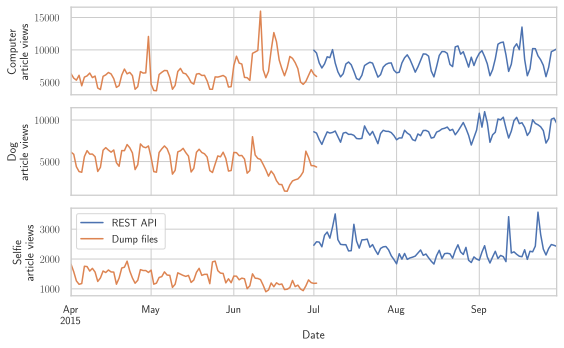

In [27]:
# Must remove an article because lacking space
articles_plot = articles.copy().tolist()
articles_plot.remove('Cat')

fig, ax = plt.subplots(len(articles_plot), 1, figsize=(8, len(articles_plot)*1.5+.5), sharex=True)

for i, (article, a) in enumerate(zip(articles_plot, ax)):
    l = df_api.plot(y=article, ax=a, legend=False)
    a.set_ylabel(f'{article}\narticle views')
    df_plot_en.plot(y=article, ax=a, legend=False)
    
    
handles, _ = l.get_legend_handles_labels()
a.legend(handles, ['REST API', 'Dump files'])
    
plt.tight_layout()
plt.xlabel('Date')

if not os.path.exists('figs'):
    os.mkdir('figs')
plt.savefig('figs/dumps_vs_api.eps', bbox_inches='tight')